In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h_transport_materials as htm
from labellines import labelLines

mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False

In [22]:
htm.ureg.define('fraction = [] = frac')
htm.ureg.define('ppm = 1e-6 fraction')

MOLAR_VOL_RT = 24.45 * htm.ureg.L * htm.ureg.mol**-1
MOLAR_MASS_H2 = 2.016 * htm.ureg.g * htm.ureg.mol**-1

def downstream_flux(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): salt permeability
        L (float): salt thickness
        D (float): diffusivity of H in the salt

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up * permeability / L * (2*summation + 1)


def sweep_gas_concentration(flux, area, gas_flow):
    return flux*area/gas_flow*MOLAR_MASS_H2

def concentration_to_ppm(concentration, molar_mass_species, molar_volume_gas):
    return (concentration * molar_volume_gas / molar_mass_species)


In [23]:
sweep_rate = 20 * htm.ureg.cm**3 * htm.ureg.min**-1
L = 0.31*htm.ureg.inches
diam = 3.07*htm.ureg.inches
area = np.pi * (diam/2) ** 2
membrane_thickness = 0.08 * htm.ureg.inches

temperature_range = [760, 970] * htm.ureg.K

In [24]:
properties = {
    "flinak": {"diffusivity": htm.diffusivities.filter(material=htm.FLINAK, author='fukada')[0], "solubility": htm.solubilities.filter(material=htm.FLINAK, author='fukada')[0]},
    "flibe": {"diffusivity": htm.diffusivities.filter(material=htm.FLIBE, author='calderoni')[0], "solubility": htm.solubilities.filter(material=htm.FLIBE, author='calderoni')[0]},
    "nickel": {"diffusivity": htm.diffusivities.filter(material=htm.NICKEL).mean(), "solubility": htm.solubilities.filter(material=htm.NICKEL).mean()}
}
for mat, props in properties.items():
    if "permeability" not in props:
        props["permeability"] = props["diffusivity"] * props["solubility"]


[substance] / [time]


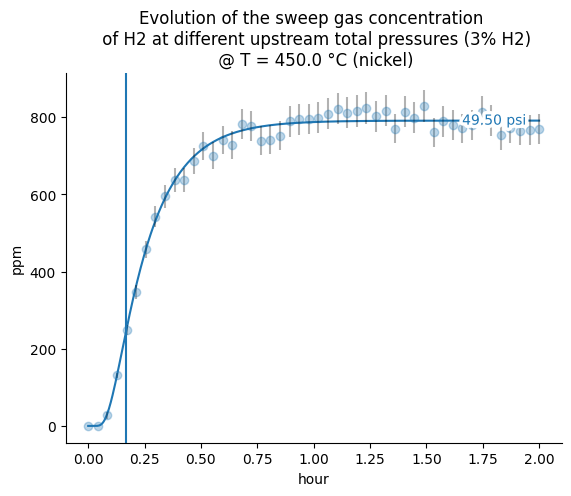

In [25]:
T = htm.ureg.Quantity(450, htm.ureg.degC).to(htm.ureg.K)

sample_rate = 1 / (2.5 * htm.ureg.min)
total_time = 2 * htm.ureg.h
t_array = np.linspace(0, total_time.to(htm.ureg.h).magnitude, num=500) * htm.ureg.h

number_samples = (total_time * sample_rate).to(htm.ureg.dimensionless)

t_samples = np.linspace(0, total_time, num=int(number_samples))

total_pressures = np.linspace(0.5, 5, num=6) * htm.ureg.atm  # total pressure
# total_pressures = [1.4 * htm.ureg.atm]

permeability = properties["nickel"]["permeability"]
diffusivity = properties["nickel"]["diffusivity"]


def downstream_flux_metal(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): salt permeability
        L (float): salt thickness
        D (float): diffusivity of H in the salt

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum(
        (-1) ** n_array * np.exp(-((np.pi * n_array) ** 2) * D / L**2 * t), axis=0
    )
    return P_up**0.5 * permeability / L * (2 * summation + 1)


plt.figure()
P_tot = 49.5 * htm.ureg.psi
partial_pressure = P_tot * 0.03
flux = downstream_flux_metal(
    t_array,
    partial_pressure,
    permeability.value(T),
    membrane_thickness,
    diffusivity.value(T),
)
flux_measured = downstream_flux_metal(
    t_samples,
    partial_pressure,
    permeability.value(T),
    membrane_thickness,
    diffusivity.value(T),
)
print((area*flux_measured).dimensionality)

concentration = sweep_gas_concentration(flux, area, sweep_rate)
concentration = concentration_to_ppm(concentration, MOLAR_MASS_H2, MOLAR_VOL_RT).to(
    htm.ureg.ppm
)
concentration[0] = 0

concentration_measured = sweep_gas_concentration(flux_measured, area, sweep_rate)
concentration_measured = concentration_to_ppm(
    concentration_measured, MOLAR_MASS_H2, MOLAR_VOL_RT
).to(htm.ureg.ppm)
concentration_measured[0] = 0

# 30 % relative error if concentration below 100 ppm
error = np.zeros_like(concentration_measured)

error_low_ppm = 0.3
indexes_low_ppm = concentration_measured < 100 * htm.ureg.ppm
error[indexes_low_ppm] = np.random.uniform(
    -error_low_ppm, error_low_ppm, concentration_measured[indexes_low_ppm].shape
)
error_high_ppm = 0.05
indexes_high_ppm = concentration_measured >= 100 * htm.ureg.ppm
error[indexes_high_ppm] = np.random.uniform(
    -error_high_ppm, error_high_ppm, concentration_measured[indexes_high_ppm].shape
)

concentration_measured *= 1 + error

error_bars = np.zeros_like(concentration_measured)
error_bars[indexes_low_ppm] = error_low_ppm
error_bars[indexes_high_ppm] = error_high_ppm
error_bars = error_bars * concentration_measured

(l,) = plt.plot(t_array, concentration, label=f"{P_tot:~.2fP}")
plt.errorbar(
    t_samples,
    concentration_measured,
    yerr=error_bars,
    fmt="o",
    ecolor="black",
    color=l.get_color(),
    alpha=0.3,
)
labelLines(plt.gca().get_lines(), xvals=[3] * 6)
plt.title(
f"Evolution of the sweep gas concentration \n of H2 at different upstream total pressures (3% H2)\n @ T = {T.to(htm.ureg.degC):~P} (nickel)"
)

plt.axvline(10 * htm.ureg.min)


In [26]:
ID = 3.5 * htm.ureg.mm
flow_rate = 20 * htm.ureg.cm**3 * htm.ureg.min**-1

cross_section = np.pi * (ID / 2) ** 2
velocity = flow_rate / cross_section
print(velocity.to(htm.ureg.cm / htm.ureg.s))
L = 5 * htm.ureg.m

time_lag = L / velocity
print(time_lag.to(htm.ureg.s))

3.464597400639899 centimeter / second
144.3169125242811 second


In [27]:
htm.ureg.define('fraction = [] = frac')
htm.ureg.define('ppm = 1e-6 fraction')

MOLAR_VOL_RT = 24.45 * htm.ureg.L * htm.ureg.mol**-1
MOLAR_MASS_H2 = 2.016 * htm.ureg.g * htm.ureg.mol**-1


def concentration_to_ppm(concentration, molar_mass_species, molar_volume_gas):
    return (concentration * molar_volume_gas / molar_mass_species)

def ppm_to_concentration(ppm, molar_mass_species, molar_volume_gas):
    return (ppm * molar_mass_species / molar_volume_gas)


def sweep_gas_concentration(flux, area, gas_flow):
    return flux*area/gas_flow*MOLAR_MASS_H2

def gas_concentration_to_flux(concentration, gas_flow):
    return concentration*gas_flow/MOLAR_MASS_H2

flow_rate = 20 * htm.ureg.cc / htm.ureg.min

In [28]:
from dateutil.parser import parse
file_path = "pre_sequence.csv"
dates = []
concentrations_rise = []
with open(file_path, "r") as file:
    for line_number, line in enumerate(file, 1):
        if "Injection date" in line:
            date = line.split(",")[-1]
            dates.append(date)
        if "hydrogen" in line:
            concentration = line.split(",")[-3]
            concentrations_rise.append(float(concentration))


# only the last seven
dates = dates[-7:]

dates_rise = [parse(date) for date in dates]
time_start = dates_rise[0]


Located 'Sample statistics:' at line 1216


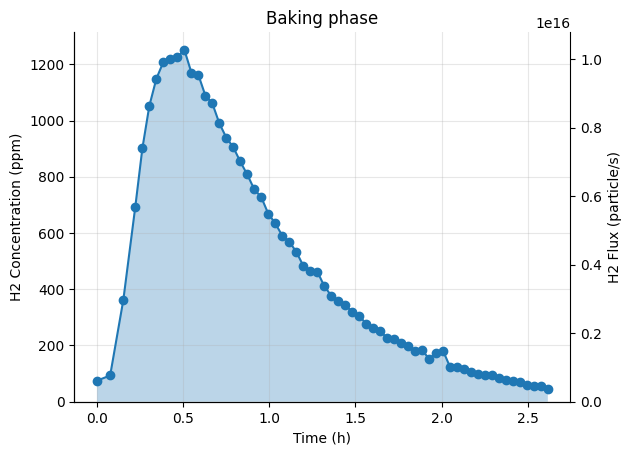

In [29]:
from read_data_from_gc import *

filename = "dry_run_baking.csv"

data = read_data(filename)
dates = [parse(date) for date in data["Injection_Acquired_Date"]]

dates = dates_rise + dates
concentrations = concentrations_rise + data["Amount_ppm"].tolist()
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.plot(times_in_hours, concentrations, marker="o")
plt.fill_between(times_in_hours, concentrations, alpha=0.3)
plt.ylabel(f"H2 Concentration ({concentrations.units})")
plt.ylim(bottom=0)
plt.xlabel("Time (h)")
plt.title("Baking phase")
plt.grid(alpha=0.3)

# add a twin y axis to show the equivalent flux
ax1 = plt.gca()
ax2 = ax1.twinx()


ylim_flux = gas_concentration_to_flux(
    ppm_to_concentration(
        ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
    ),
    flow_rate,
).to(htm.ureg.particle / htm.ureg.s)
ax2.set_ylim(ylim_flux)
ax2.yaxis.set_units(ylim_flux.units)
# set right axis visible
ax2.spines["right"].set_visible(True)
ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
plt.show()

Located 'Sample statistics:' at line 2655


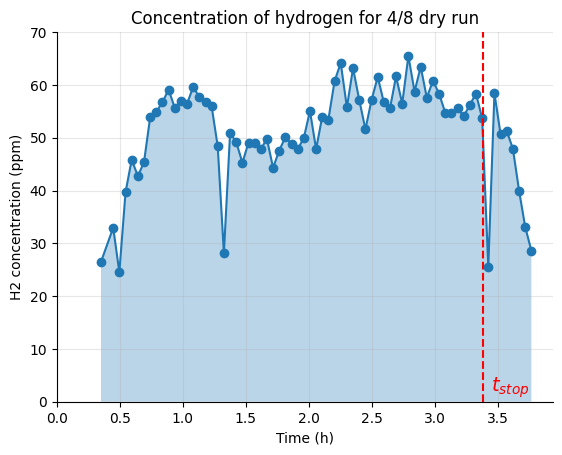

In [30]:
from read_data_from_gc import *

filename = "dry_run_04082024.csv"

data = read_data(filename)
dates = [parse(date) for date in data["Injection_Acquired_Date"]]

concentrations = data["Amount_ppm"].tolist()
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
time_start = parse("2024-04-08 10:50:00-04:00")
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.plot(times_in_hours, concentrations, marker="o")
plt.fill_between(times_in_hours, concentrations, alpha=0.3)
plt.ylabel(f"H2 concentration ({concentrations.units: ~P})")
plt.ylim(bottom=0)
plt.xlabel("Time (h)")
plt.grid(alpha=0.3)
plt.xlim(left=0)

# add a twin y axis to show the equivalent flux
# ax1 = plt.gca()
# ax2 = ax1.twinx()

t_stop = parse("2024-04-08 14:13:00-04:00")
plt.axvline((t_stop - time_start).total_seconds() / 3600, color="red", linestyle="--")
plt.annotate(r"$t_{stop}$", ((t_stop - time_start).total_seconds() / 3600 * 1.02, 1.85), color="red", fontsize=14)
plt.ylim(top = 70)

# ylim_flux = gas_concentration_to_flux(
#     ppm_to_concentration(
#         ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
#     ),
#     flow_rate,
# ).to(htm.ureg.particle / htm.ureg.s)
# ax2.set_ylim(ylim_flux)
# ax2.yaxis.set_units(ylim_flux.units)
# # set right axis visible
# ax2.spines["right"].set_visible(True)
# ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
#plt.savefig("dry_run.svg")
plt.title("Concentration of hydrogen for 4/8 dry run")
plt.show()

Located 'Sample statistics:' at line 2004
Located 'Sample statistics:' at line 7505


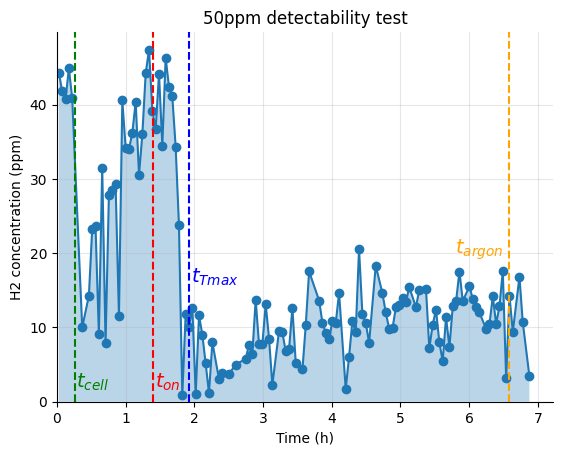

In [31]:
from read_data_from_gc import *

filename = "50ppm_detectability_04_22.csv"
filename2 = '50_ppm_detectability_continued_04_22.csv'

data = read_data(filename)
data2 = read_data(filename2)
dates = [parse(date) for date in data["Injection_Acquired_Date"]]

dates = dates + [parse(date) for date in data2["Injection_Acquired_Date"]]
concentrations = data["Amount_ppm"].tolist() + data2["Amount_ppm"].tolist()
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
time_start = parse("2024-04-22 11:05:00-04:00")
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.plot(times_in_hours, concentrations, marker="o")
plt.fill_between(times_in_hours, concentrations, alpha=0.3)
plt.ylabel(f"H2 concentration ({concentrations.units: ~P})")
plt.ylim(bottom=0)
plt.xlabel("Time (h)")
plt.grid(alpha=0.3)
plt.xlim(left=0)

t_cell = parse("2024-04-22 11:21:00-04:00")
plt.axvline((t_cell - time_start).total_seconds() / 3600, color="green", linestyle="--")
plt.annotate(r"$t_{cell}$", ((t_cell - time_start).total_seconds() / 3600 * 1.02, 1.85), color="green", fontsize=14)

t_on = parse("2024-04-22 12:29:00-04:00")
plt.axvline((t_on - time_start).total_seconds() / 3600, color="red", linestyle="--")
plt.annotate(r"$t_{on}$", ((t_on - time_start).total_seconds() / 3600 * 1.02, 1.85), color="red", fontsize=14)

t_Tmax = parse("2024-04-22 13:00:00-04:00")
plt.axvline((t_Tmax - time_start).total_seconds() / 3600, color="blue", linestyle="--")
plt.annotate(r"$t_{Tmax}$", ((t_Tmax - time_start).total_seconds() / 3600 * 1.02, 16), color="blue", fontsize=14)

t_argon = parse("2024-04-22 17:40:00-04:00")
plt.axvline((t_argon - time_start).total_seconds() / 3600, color="orange", linestyle="--")
plt.annotate(r"$t_{argon}$", ((t_argon - time_start).total_seconds() / 3600 * 0.88, 20), color="orange", fontsize=14)

# add a twin y axis to show the equivalent flux
# ax1 = plt.gca()
# ax2 = ax1.twinx()


# ylim_flux = gas_concentration_to_flux(
#     ppm_to_concentration(
#         ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
#     ),
#     flow_rate,
# ).to(htm.ureg.particle / htm.ureg.s)
# ax2.set_ylim(ylim_flux)
# ax2.yaxis.set_units(ylim_flux.units)
# # set right axis visible
# ax2.spines["right"].set_visible(True)
# ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
#plt.savefig("dry_run.svg")
plt.title("50ppm detectability test")
plt.show()

Located 'Sample statistics:' at line 1844


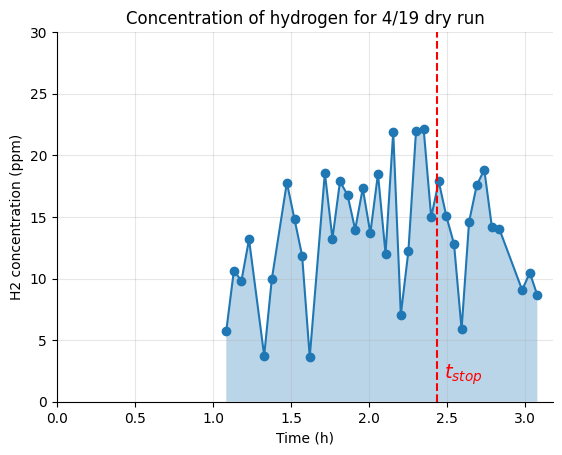

In [32]:
from read_data_from_gc import *

filename = "dry_run_04_19.csv"


data = read_data(filename)
dates = [parse(date) for date in np.delete(data["Injection_Acquired_Date"],0)]

# have to delete the first data point for this data set
concentrations = np.delete(data["Amount_ppm"].tolist(),0)
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
time_start = parse("2024-04-19 12:22:00-04:00")
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.plot(times_in_hours, concentrations, marker="o")
plt.fill_between(times_in_hours, concentrations, alpha=0.3)
plt.ylabel(f"H2 concentration ({concentrations.units: ~P})")
plt.ylim(bottom=0)
plt.xlabel("Time (h)")
plt.grid(alpha=0.3)
plt.xlim(left=0)

t_stop = parse("2024-04-19 14:48:00-04:00")
plt.axvline((t_stop - time_start).total_seconds() / 3600, color="red", linestyle="--")
plt.annotate(r"$t_{stop}$", ((t_stop - time_start).total_seconds() / 3600 * 1.02, 1.85), color="red", fontsize=14)

# add a twin y axis to show the equivalent flux
# ax1 = plt.gca()
# ax2 = ax1.twinx()
plt.ylim(top = 30)

# ylim_flux = gas_concentration_to_flux(
#     ppm_to_concentration(
#         ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
#     ),
#     flow_rate,
# ).to(htm.ureg.particle / htm.ureg.s)
# ax2.set_ylim(ylim_flux)
# ax2.yaxis.set_units(ylim_flux.units)
# # set right axis visible
# ax2.spines["right"].set_visible(True)
# ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
#plt.savefig("dry_run.svg")
plt.title("Concentration of hydrogen for 4/19 dry run")
plt.show()

Located 'Sample statistics:' at line 1502


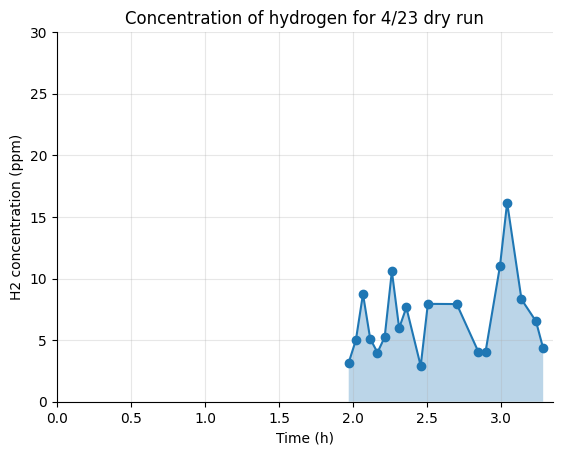

In [33]:
from read_data_from_gc import *

filename = "dry_run_4-23_inprogress.csv"


data = read_data(filename)
dates = [parse(date) for date in data["Injection_Acquired_Date"]]

concentrations = data["Amount_ppm"].tolist()
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
time_start = parse("2024-04-23 11:14:45-04:00")
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.plot(times_in_hours, concentrations, marker="o")
plt.fill_between(times_in_hours, concentrations, alpha=0.3)
plt.ylabel(f"H2 concentration ({concentrations.units: ~P})")
plt.ylim(bottom=0)
plt.xlabel("Time (h)")
plt.grid(alpha=0.3)
plt.xlim(left=0)

'''
t_stop = parse("2024-04-19 14:48:00-04:00")
plt.axvline((t_stop - time_start).total_seconds() / 3600, color="red", linestyle="--")
plt.annotate(r"$t_{stop}$", ((t_stop - time_start).total_seconds() / 3600 * 1.02, 1.85), color="red", fontsize=14)
'''
# add a twin y axis to show the equivalent flux
# ax1 = plt.gca()
# ax2 = ax1.twinx()
plt.ylim(top = 30)

# ylim_flux = gas_concentration_to_flux(
#     ppm_to_concentration(
#         ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
#     ),
#     flow_rate,
# ).to(htm.ureg.particle / htm.ureg.s)
# ax2.set_ylim(ylim_flux)
# ax2.yaxis.set_units(ylim_flux.units)
# # set right axis visible
# ax2.spines["right"].set_visible(True)
# ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
#plt.savefig("dry_run.svg")
plt.title("Concentration of hydrogen for 4/23 dry run")
plt.show()

Located 'Sample statistics:' at line 10197


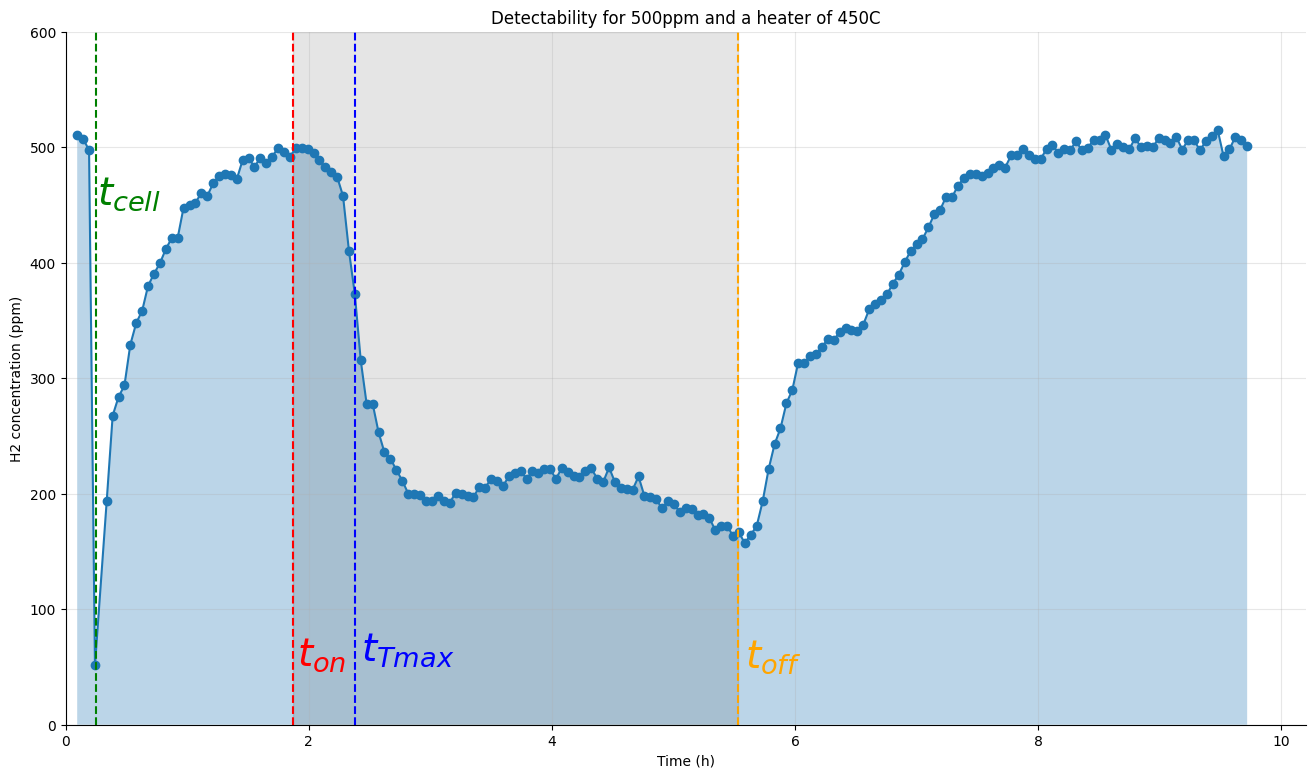

In [34]:
from read_data_from_gc import *

filename = "500ppm_detectability_450C.csv"

data = read_data(filename)
dates = [parse(date) for date in data["Injection_Acquired_Date"]]

concentrations = data["Amount_ppm"].tolist()
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
time_start = parse("2024-04-24 11:07:00-04:00")
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.figure(figsize = (16,9))
plt.plot(times_in_hours[2:200], concentrations[2:200], marker="o")
plt.fill_between(times_in_hours[2:200], concentrations[2:200], alpha=0.3)
plt.ylabel(f"H2 concentration ({concentrations.units: ~P})")
plt.ylim(bottom=0, top = 600)
plt.xlabel("Time (h)")
plt.grid(alpha=0.3)
plt.xlim(left=0)

# add a twin y axis to show the equivalent flux
# ax1 = plt.gca()
# ax2 = ax1.twinx()

# All of the times for various events during the tests
t_cell = parse("2024-04-24 11:22:00-04:00")
plt.axvline((t_cell - time_start).total_seconds() / 3600, color="green", linestyle="--")
plt.annotate(r"$t_{cell}$", ((t_cell - time_start).total_seconds() / 3600 * 1.02, 450.85), color="green", fontsize=28)

t_on = parse("2024-04-24 12:59:00-04:00")
plt.axvline((t_on - time_start).total_seconds() / 3600, color="red", linestyle="--")
plt.annotate(r"$t_{on}$", ((t_on - time_start).total_seconds() / 3600 * 1.02, 51.85), color="red", fontsize=28)

t_Tmax = parse("2024-04-24 13:30:00-04:00")
plt.axvline((t_Tmax - time_start).total_seconds() / 3600, color="blue", linestyle="--")
plt.annotate(r"$t_{Tmax}$", ((t_Tmax - time_start).total_seconds() / 3600 * 1.02, 56), color="blue", fontsize=28)

t_off = parse("2024-04-24 16:39:00-04:00")
plt.axvline((t_off - time_start).total_seconds() / 3600, color="orange", linestyle="--")
plt.annotate(r"$t_{off}$", ((t_off - time_start).total_seconds() / 3600 * 1.01, 50), color="orange", fontsize=28)

# Shading the region between t_on and t_off
plt.axvspan((t_on - time_start).total_seconds() / 3600,(t_off - time_start).total_seconds() / 3600, alpha=0.1, color='black')




# ylim_flux = gas_concentration_to_flux(
#     ppm_to_concentration(
#         ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
#     ),
#     flow_rate,
# ).to(htm.ureg.particle / htm.ureg.s)
# ax2.set_ylim(ylim_flux)
# ax2.yaxis.set_units(ylim_flux.units)
# # set right axis visible
# ax2.spines["right"].set_visible(True)
# ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
#plt.savefig("dry_run.svg")
plt.title("Detectability for 500ppm and a heater of 450C")
plt.show()

Located 'Sample statistics:' at line 9500


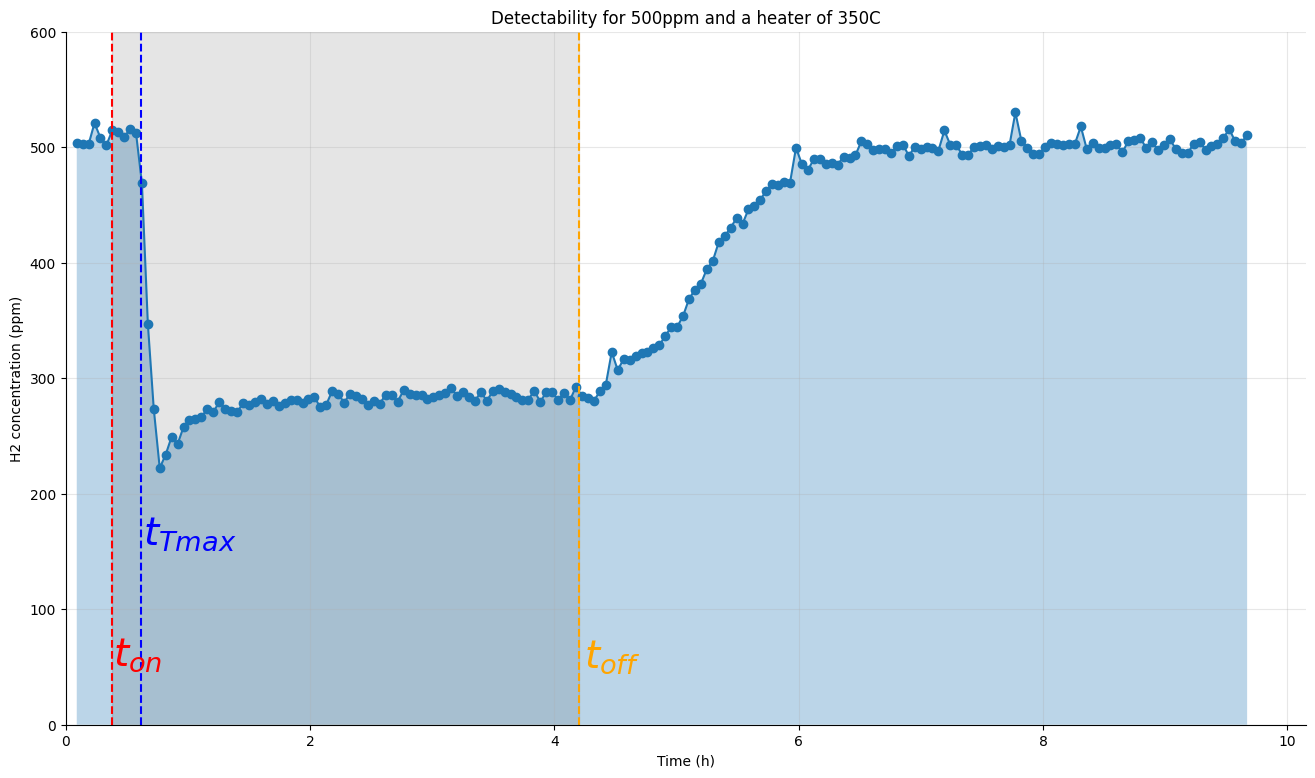

In [35]:
from read_data_from_gc import *

filename = "500ppm_detectability_350C.csv"

data = read_data(filename)
dates = [parse(date) for date in data["Injection_Acquired_Date"]]

concentrations = data["Amount_ppm"].tolist()
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
time_start = parse("2024-04-25 11:48:00-04:00")
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.figure(figsize = (16,9))
plt.plot(times_in_hours[2:200], concentrations[2:200], marker="o")
plt.fill_between(times_in_hours[2:200], concentrations[2:200], alpha=0.3)
plt.ylabel(f"H2 concentration ({concentrations.units: ~P})")
plt.ylim(bottom=0, top = 600)
plt.xlabel("Time (h)")
plt.grid(alpha=0.3)
plt.xlim(left=0)

# add a twin y axis to show the equivalent flux
# ax1 = plt.gca()
# ax2 = ax1.twinx()
t_on = parse("2024-04-25 12:11:00-04:00")
plt.axvline((t_on - time_start).total_seconds() / 3600, color="red", linestyle="--")
plt.annotate(r"$t_{on}$", ((t_on - time_start).total_seconds() / 3600 * 1.02, 51.85), color="red", fontsize=28)

t_Tmax = parse("2024-04-25 12:25:00-04:00")
plt.axvline((t_Tmax - time_start).total_seconds() / 3600, color="blue", linestyle="--")
plt.annotate(r"$t_{Tmax}$", ((t_Tmax - time_start).total_seconds() / 3600 * 1.02, 156), color="blue", fontsize=28)

t_off = parse("2024-04-25 16:00:00-04:00")
plt.axvline((t_off - time_start).total_seconds() / 3600, color="orange", linestyle="--")
plt.annotate(r"$t_{off}$", ((t_off - time_start).total_seconds() / 3600 * 1.01, 50), color="orange", fontsize=28)


# Shading the region between t_on and t_off
plt.axvspan((t_on - time_start).total_seconds() / 3600,(t_off - time_start).total_seconds() / 3600, alpha=0.1, color='black')
# ylim_flux = gas_concentration_to_flux(
#     ppm_to_concentration(
#         ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
#     ),
#     flow_rate,
# ).to(htm.ureg.particle / htm.ureg.s)
# ax2.set_ylim(ylim_flux)
# ax2.yaxis.set_units(ylim_flux.units)
# # set right axis visible
# ax2.spines["right"].set_visible(True)
# ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
#plt.savefig("dry_run.svg")
plt.title("Detectability for 500ppm and a heater of 350C")
plt.show()

Located 'Sample statistics:' at line 11543


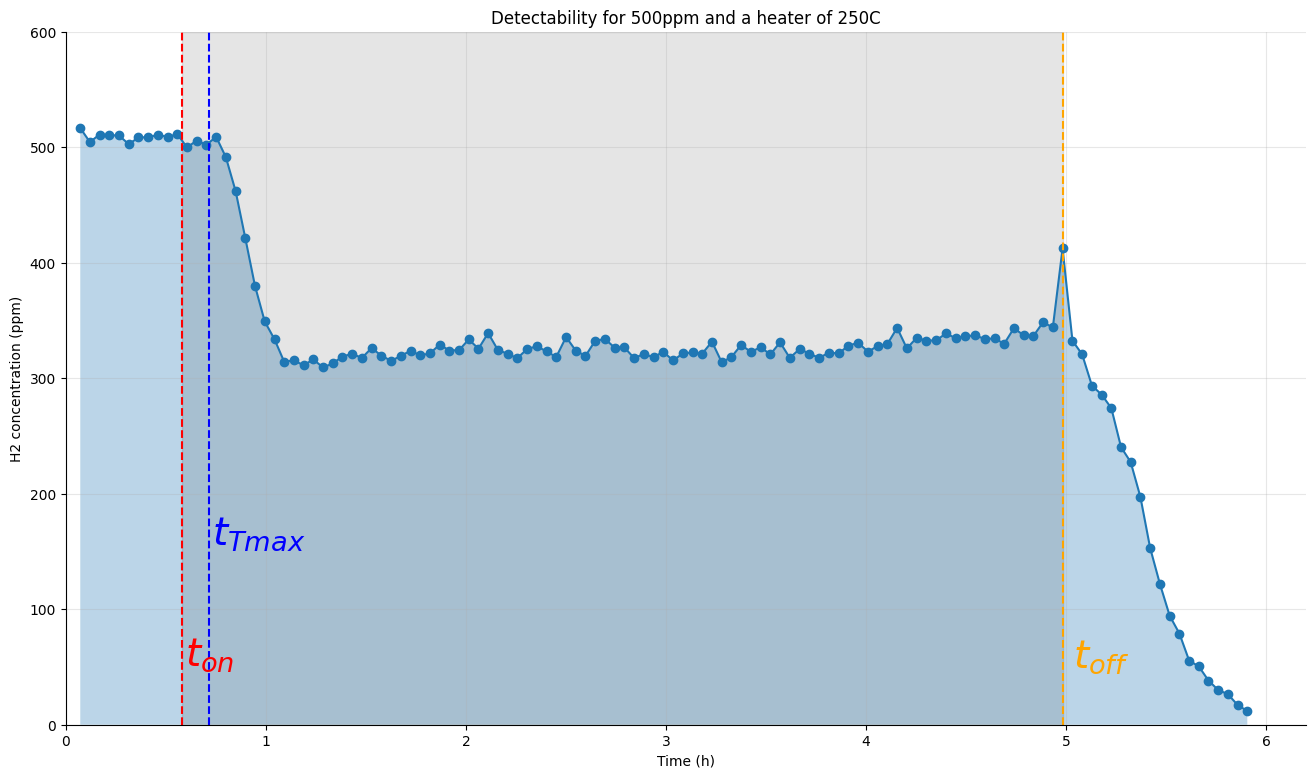

In [36]:
from read_data_from_gc import *

filename = "500ppm_detectability_250C.csv"

data = read_data(filename)
dates = [parse(date) for date in data["Injection_Acquired_Date"]]

concentrations = data["Amount_ppm"].tolist()
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
time_start = parse("2024-04-26 10:52:00-04:00")
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.figure(figsize = (16,9))
plt.plot(times_in_hours[2:200], concentrations[2:200], marker="o")
plt.fill_between(times_in_hours[2:200], concentrations[2:200], alpha=0.3)
plt.ylabel(f"H2 concentration ({concentrations.units: ~P})")
plt.ylim(bottom=0, top = 600)
plt.xlabel("Time (h)")
plt.grid(alpha=0.3)
plt.xlim(left=0)

# add a twin y axis to show the equivalent flux
# ax1 = plt.gca()
# ax2 = ax1.twinx()
t_on = parse("2024-04-26 11:27:00-04:00")
plt.axvline((t_on - time_start).total_seconds() / 3600, color="red", linestyle="--")
plt.annotate(r"$t_{on}$", ((t_on - time_start).total_seconds() / 3600 * 1.02, 51.85), color="red", fontsize=28)

t_Tmax = parse("2024-04-26 11:35:00-04:00")
plt.axvline((t_Tmax - time_start).total_seconds() / 3600, color="blue", linestyle="--")
plt.annotate(r"$t_{Tmax}$", ((t_Tmax - time_start).total_seconds() / 3600 * 1.02, 156), color="blue", fontsize=28)

t_off = parse("2024-04-26 15:51:00-04:00")
plt.axvline((t_off - time_start).total_seconds() / 3600, color="orange", linestyle="--")
plt.annotate(r"$t_{off}$", ((t_off - time_start).total_seconds() / 3600 * 1.01, 50), color="orange", fontsize=28)


# Shading the region between t_on and t_off
plt.axvspan((t_on - time_start).total_seconds() / 3600,(t_off - time_start).total_seconds() / 3600, alpha=0.1, color='black')
# ylim_flux = gas_concentration_to_flux(
#     ppm_to_concentration(
#         ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
#     ),
#     flow_rate,
# ).to(htm.ureg.particle / htm.ureg.s)
# ax2.set_ylim(ylim_flux)
# ax2.yaxis.set_units(ylim_flux.units)
# # set right axis visible
# ax2.spines["right"].set_visible(True)
# ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
#plt.savefig("dry_run.svg")
plt.title("Detectability for 500ppm and a heater of 250C")
plt.show()

Located 'Sample statistics:' at line 5913


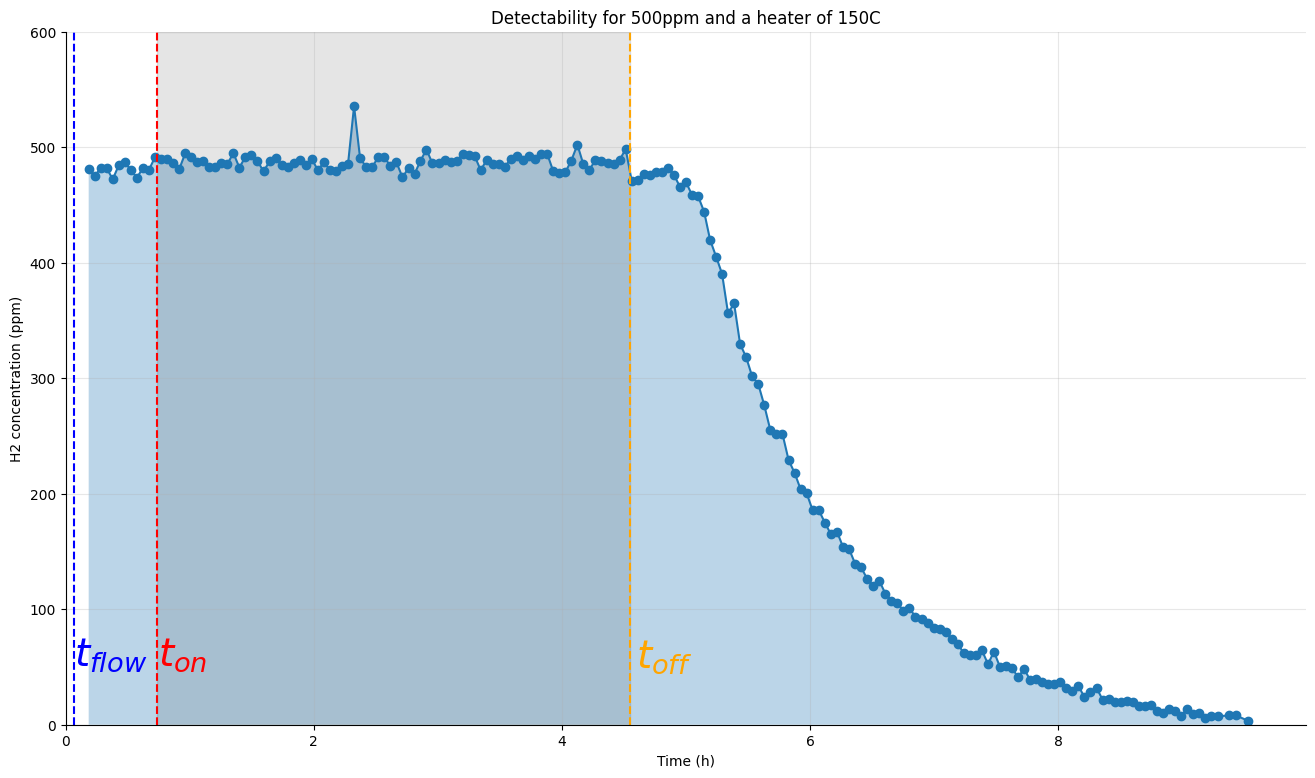

In [37]:
from read_data_from_gc import *

filename = "500ppm_detectability_150C.csv"

data = read_data(filename)
dates = [parse(date) for date in data["Injection_Acquired_Date"]]

concentrations = data["Amount_ppm"].tolist()
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
time_start = parse("2024-04-29 10:52:00-04:00")
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.figure(figsize = (16,9))
plt.plot(times_in_hours[2:200], concentrations[2:200], marker="o")
plt.fill_between(times_in_hours[2:200], concentrations[2:200], alpha=0.3)
plt.ylabel(f"H2 concentration ({concentrations.units: ~P})")
plt.ylim(bottom=0, top = 600)
plt.xlabel("Time (h)")
plt.grid(alpha=0.3)
plt.xlim(left=0)

# add a twin y axis to show the equivalent flux
# ax1 = plt.gca()
# ax2 = ax1.twinx()
t_flow = parse("2024-04-29 10:56:00-04:00")
plt.axvline((t_flow - time_start).total_seconds() / 3600, color="blue", linestyle="--")
plt.annotate(r"$t_{flow}$", ((t_flow - time_start).total_seconds() / 3600 * 1.02, 51.85), color="blue", fontsize=28)


t_on = parse("2024-04-29 11:36:00-04:00")
plt.axvline((t_on - time_start).total_seconds() / 3600, color="red", linestyle="--")
plt.annotate(r"$t_{on}$", ((t_on - time_start).total_seconds() / 3600 * 1.02, 51.85), color="red", fontsize=28)

t_off = parse("2024-04-29 15:25:00-04:00")
plt.axvline((t_off - time_start).total_seconds() / 3600, color="orange", linestyle="--")
plt.annotate(r"$t_{off}$", ((t_off - time_start).total_seconds() / 3600 * 1.01, 50), color="orange", fontsize=28)


# Shading the region between t_on and t_off
plt.axvspan((t_on - time_start).total_seconds() / 3600,(t_off - time_start).total_seconds() / 3600, alpha=0.1, color='black')
# ylim_flux = gas_concentration_to_flux(
#     ppm_to_concentration(
#         ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
#     ),
#     flow_rate,
# ).to(htm.ureg.particle / htm.ureg.s)
# ax2.set_ylim(ylim_flux)
# ax2.yaxis.set_units(ylim_flux.units)
# # set right axis visible
# ax2.spines["right"].set_visible(True)
# ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
#plt.savefig("dry_run.svg")
plt.title("Detectability for 500ppm and a heater of 150C")
plt.show()

Located 'Sample statistics:' at line 1457


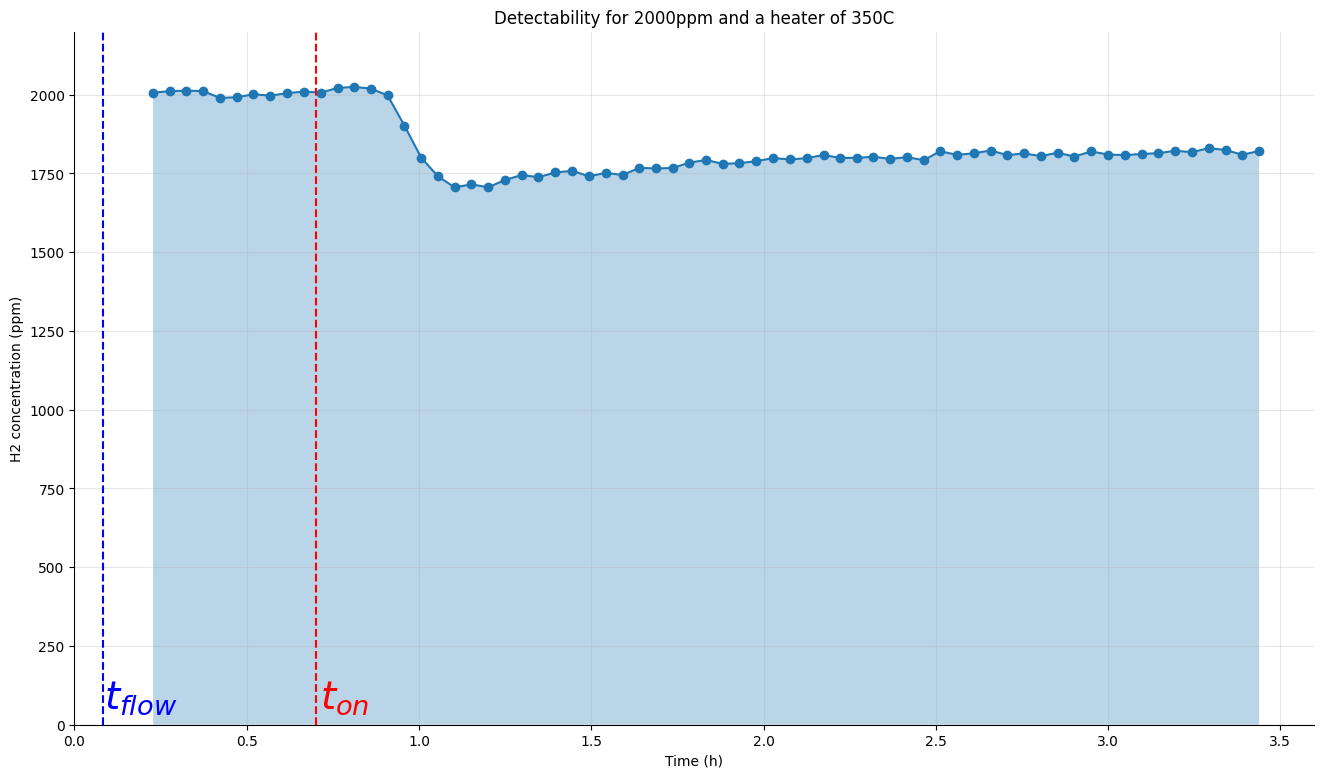

In [38]:
from read_data_from_gc import *

filename = "2000ppm_detectability_350C_inprogress.csv"

data = read_data(filename)
dates = [parse(date) for date in data["Injection_Acquired_Date"]]

concentrations = data["Amount_ppm"].tolist()
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
time_start = parse("2024-04-30 11:08:00-04:00")
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.figure(figsize = (16,9))
plt.plot(times_in_hours[2:200], concentrations[2:200], marker="o")
plt.fill_between(times_in_hours[2:200], concentrations[2:200], alpha=0.3)
plt.ylabel(f"H2 concentration ({concentrations.units: ~P})")
plt.ylim(bottom=0, top = 2200)
plt.xlabel("Time (h)")
plt.grid(alpha=0.3)
plt.xlim(left=0)

# add a twin y axis to show the equivalent flux
# ax1 = plt.gca()
# ax2 = ax1.twinx()
t_flow = parse("2024-04-30 11:13:00-04:00")
plt.axvline((t_flow - time_start).total_seconds() / 3600, color="blue", linestyle="--")
plt.annotate(r"$t_{flow}$", ((t_flow - time_start).total_seconds() / 3600 * 1.02, 51.85), color="blue", fontsize=28)


t_on = parse("2024-04-30 11:50:00-04:00")
plt.axvline((t_on - time_start).total_seconds() / 3600, color="red", linestyle="--")
plt.annotate(r"$t_{on}$", ((t_on - time_start).total_seconds() / 3600 * 1.02, 51.85), color="red", fontsize=28)

'''
t_off = parse("2024-04-29 15:25:00-04:00")
plt.axvline((t_off - time_start).total_seconds() / 3600, color="orange", linestyle="--")
plt.annotate(r"$t_{off}$", ((t_off - time_start).total_seconds() / 3600 * 1.01, 50), color="orange", fontsize=28)
'''

# Shading the region between t_on and t_off
#plt.axvspan((t_on - time_start).total_seconds() / 3600,(t_off - time_start).total_seconds() / 3600, alpha=0.1, color='black')
# ylim_flux = gas_concentration_to_flux(
#     ppm_to_concentration(
#         ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
#     ),
#     flow_rate,
# ).to(htm.ureg.particle / htm.ureg.s)
# ax2.set_ylim(ylim_flux)
# ax2.yaxis.set_units(ylim_flux.units)
# # set right axis visible
# ax2.spines["right"].set_visible(True)
# ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
#plt.savefig("dry_run.svg")
plt.title("Detectability for 2000ppm and a heater of 350C")
plt.show()

Located 'Sample statistics:' at line 6019


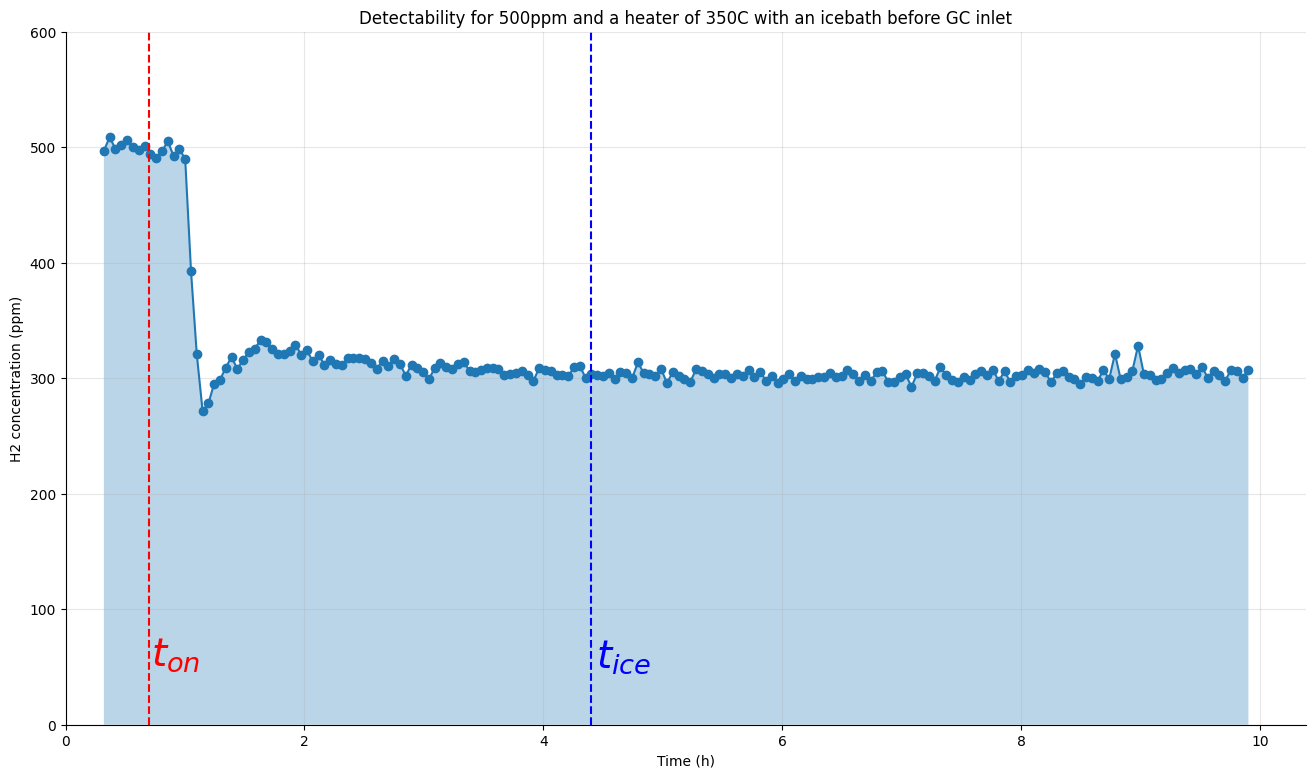

In [39]:
from read_data_from_gc import *

filename = "500ppm_350C_icebath.csv"

data = read_data(filename)
dates = [parse(date) for date in data["Injection_Acquired_Date"][4:300]]

concentrations = data["Amount_ppm"][4:300].tolist()
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
time_start = parse("2024-05-01 11:16:00-04:00")
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.figure(figsize = (16,9))
plt.plot(times_in_hours[2:200], concentrations[2:200], marker="o")
plt.fill_between(times_in_hours[2:200], concentrations[2:200], alpha=0.3)
plt.ylabel(f"H2 concentration ({concentrations.units: ~P})")
plt.ylim(bottom=0, top = 600)
plt.xlabel("Time (h)")
plt.grid(alpha=0.3)
plt.xlim(left=0)


t_on = parse("2024-05-01 11:58:00-04:00")
plt.axvline((t_on - time_start).total_seconds() / 3600, color="red", linestyle="--")
plt.annotate(r"$t_{on}$", ((t_on - time_start).total_seconds() / 3600 * 1.02, 51.85), color="red", fontsize=28)


t_ice = parse("2024-05-01 15:40:00-04:00")
plt.axvline((t_ice - time_start).total_seconds() / 3600, color="blue", linestyle="--")
plt.annotate(r"$t_{ice}$", ((t_ice - time_start).total_seconds() / 3600 * 1.01, 50), color="blue", fontsize=28)


# Shading the region between t_on and t_off
#plt.axvspan((t_on - time_start).total_seconds() / 3600,(t_off - time_start).total_seconds() / 3600, alpha=0.1, color='black')
# ylim_flux = gas_concentration_to_flux(
#     ppm_to_concentration(
#         ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
#     ),
#     flow_rate,
# ).to(htm.ureg.particle / htm.ureg.s)
# ax2.set_ylim(ylim_flux)
# ax2.yaxis.set_units(ylim_flux.units)
# # set right axis visible
# ax2.spines["right"].set_visible(True)
# ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
#plt.savefig("dry_run.svg")
plt.title("Detectability for 500ppm and a heater of 350C with an icebath before GC inlet")
plt.show()

Located 'Sample statistics:' at line 5864


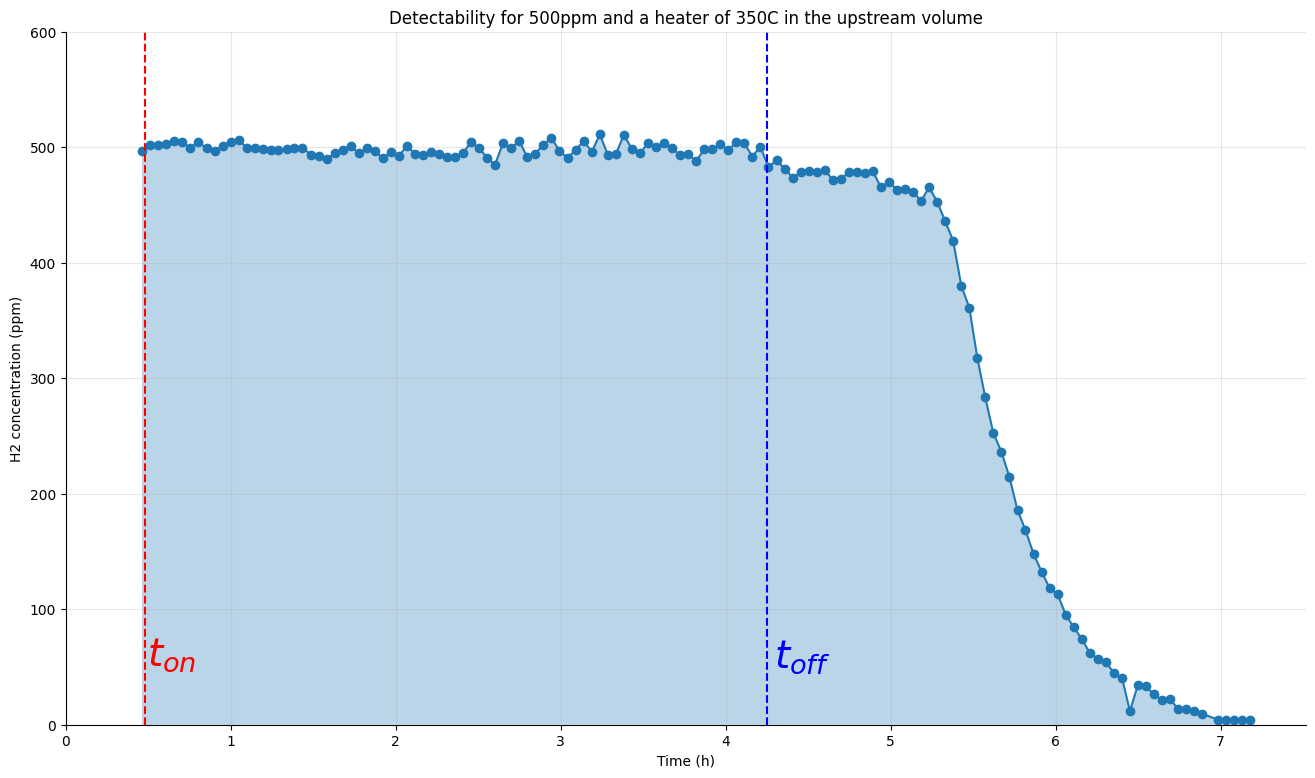

In [40]:
from read_data_from_gc import *

filename = "500ppm_upstream_350C.csv"

data = read_data(filename)
dates = [parse(date) for date in data["Injection_Acquired_Date"][4:300]]

concentrations = data["Amount_ppm"][4:300].tolist()
concentrations *= htm.ureg.ppm

# Converting list of datetime.datetime objects to list of times in seconds since time_start
time_start = parse("2024-05-08 11:43:00-04:00")
times_in_seconds = np.array(convert_dates_to_time(dates, time_start))
times_in_hours = times_in_seconds / 3600
plt.figure(figsize = (16,9))
plt.plot(times_in_hours[2:200], concentrations[2:200], marker="o")
plt.fill_between(times_in_hours[2:200], concentrations[2:200], alpha=0.3)
plt.ylabel(f"H2 concentration ({concentrations.units: ~P})")
plt.ylim(bottom=0, top = 600)
plt.xlabel("Time (h)")
plt.grid(alpha=0.3)
plt.xlim(left=0)


t_on = parse("2024-05-08 12:12:00-04:00")
plt.axvline((t_on - time_start).total_seconds() / 3600, color="red", linestyle="--")
plt.annotate(r"$t_{on}$", ((t_on - time_start).total_seconds() / 3600 * 1.02, 51.85), color="red", fontsize=28)


t_off = parse("2024-05-08 15:58:00-04:00")
plt.axvline((t_off - time_start).total_seconds() / 3600, color="blue", linestyle="--")
plt.annotate(r"$t_{off}$", ((t_off - time_start).total_seconds() / 3600 * 1.01, 50), color="blue", fontsize=28)


# Shading the region between t_on and t_off
#plt.axvspan((t_on - time_start).total_seconds() / 3600,(t_off - time_start).total_seconds() / 3600, alpha=0.1, color='black')
# ylim_flux = gas_concentration_to_flux(
#     ppm_to_concentration(
#         ax1.get_ylim() * concentrations.units, MOLAR_MASS_H2, MOLAR_VOL_RT
#     ),
#     flow_rate,
# ).to(htm.ureg.particle / htm.ureg.s)
# ax2.set_ylim(ylim_flux)
# ax2.yaxis.set_units(ylim_flux.units)
# # set right axis visible
# ax2.spines["right"].set_visible(True)
# ax2.set_ylabel(f"H2 Flux ({ylim_flux.units: ~P})")
#plt.savefig("dry_run.svg")
plt.title("Detectability for 500ppm and a heater of 350C in the upstream volume")
plt.show()